In [4]:
import numpy   as np
import pandas  as pd
import seaborn as sns

from matplotlib              import pyplot as plt
from sklearn.ensemble        import GradientBoostingClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing   import StandardScaler

In [27]:
data = pd.read_csv('../features.csv').drop(['barracks_status_dire',
                                            'barracks_status_radiant',
                                            'duration',
                                            'tower_status_dire',
                                            'tower_status_radiant'], axis=1)
data.head()

,match_id,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,...,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,radiant_win
0,0,1430198770,7,11,5,2098,1489,20,0,0,...,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0,1
1,1,1430220345,0,42,4,1188,1033,9,0,1,...,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0,1
2,2,1430227081,7,33,4,1319,1270,22,0,0,...,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0,0
3,3,1430263531,1,29,4,1779,1056,14,0,0,...,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0,0
4,4,1430282290,7,13,4,1431,1090,8,1,0,...,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0,0


# EDA

## Missing data

In [6]:
data.isnull().sum().where(lambda x: x != 0).dropna().astype(int)

first_blood_time               19553
first_blood_team               19553
first_blood_player1            19553
first_blood_player2            43987
radiant_bottle_time            15691
radiant_courier_time             692
radiant_flying_courier_time    27479
radiant_first_ward_time         1836
dire_bottle_time               16143
dire_courier_time                676
dire_flying_courier_time       26098
dire_first_ward_time            1826
dtype: int32

Признаки, показаные выше, имеют пропуски среди своих значений. В данном датасэте пропуски обусловлены действиями(а точнее их отсутствием) игроков. Например, значения, относящиеся к пролитию первой крови(начинающиеся на first_blood), имеют пропуски из-за того, что ни один игрок не убил другого за первые 5 минут игры. Далее видно, что есть пропуски в признаках, связанных с покупкой вардов и их установкой, ботла и курьера, а также апгрейдом последнего. Это связанно с тем, что в играх с пропусками значений этих признаков ни один игрок не покупал ботл, варды и курьера, не апгрейдил курьера и не ставил варды.

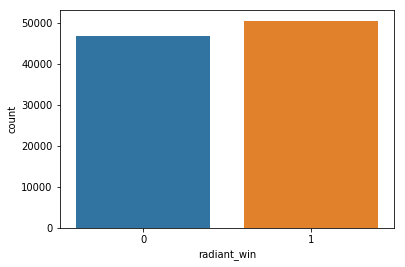

In [7]:
sns.countplot('radiant_win', data=data);

# Feature engineering

In [32]:
data = data.fillna(data.mean())
len(data)

97230

In [48]:
X = data.drop(['radiant_win'], axis=1)
y = data['radiant_win']
    
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_scaled = pd.DataFrame(X_scaled)
# X_train, X_holdout, y_train, y_holdout = train_test_split(X_scaled, y, test_size=0.3)

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3)

In [ ]:
for attr in ['kills', 'deaths', 'lh', 'gold', 'level', 'xp']:
    X_train['radiant_%s' % attr]=X_train.filter(regex=('^r._%s' % attr)).sum(axis=1)
    X_train['dire_%s' % attr]=X_train.filter(regex=('^d._%s' % attr)).sum(axis=1)
    X_train['%s_diff' % attr]=X_train['radiant_%s' % attr] - X_train['dire_%s' % attr]

# for attr in ['kills', 'deaths', 'lh', 'gold', 'level', 'xp']:
#     X.drop(['radiant_%s' % attr], axis = 1, inplace = True)
#     X.drop(['dire_%s' % attr], axis = 1, inplace = True)


In [66]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=50).fit(X_train, y_train)
sorted(zip(clf.feature_importances_, X_train.columns), reverse=True)[:20]

[(0.038241867361545105, 'gold_diff'),
 (0.02899317445358121, 'xp_diff'),
 (0.028427131769350567, 'lh_diff'),
 (0.02500543774694663, 'dire_gold'),
 (0.023467569207126622, 'radiant_gold'),
 (0.017699761052279203, 'radiant_lh'),
 (0.01735901560284693, 'radiant_xp'),
 (0.017069439260285788, 'dire_xp'),
 (0.01639133409187874, 'dire_lh'),
 (0.012527570210256644, 'r1_gold'),
 (0.012316457311520992, 'r2_gold'),
 (0.012185923797567128, 'd2_xp'),
 (0.012078836534292101, 'r4_xp'),
 (0.012043973517657796, 'd2_gold'),
 (0.012022654103179549, 'start_time'),
 (0.012001421757278115, 'd4_gold'),
 (0.01196955372656271, 'r4_gold'),
 (0.011928400968331324, 'r5_xp'),
 (0.011926257268112188, 'match_id'),
 (0.011912672461546163, 'd1_gold')]

In [63]:
pd.DataFrame(StandardScaler().fit_transform(pd.concat([X_train, y_train], axis=1)), columns=pd.concat([X_train, y_train], axis=1).columns) \
    .cov()[['radiant_win',]] \
    .abs() \
    .sort_values(by='radiant_win', ascending=False)[:20]

,radiant_win
radiant_win,1.000015
gold_diff,0.363790
xp_diff,0.320009
lh_diff,0.303785
radiant_gold,0.255220
dire_gold,0.252267
deaths_diff,0.247092
kills_diff,0.246316
level_diff,0.242798
radiant_lh,0.225694


# GradientBoostingClassifier

## Hyperparameter tuning

In [ ]:
n_estimators = range(10, 121, 10)

gbc_grid = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid={'n_estimators': n_estimators}, cv=5, scoring=)
gbc_grid.fit(X_train, y_train)

cv_scores = pd.DataFrame(gbc_grid.cv_results_)

holdout_scores = []
for n in n_estimators:
    gbc_clf = GradientBoostingClassifier(n_estimators=n).fit(X_train, y_train)
    holdout_scores.append(accuracy_score(y_holdout, gbc_clf.predict(X_holdout)))
    
plt.plot(n_estimators, cv_scores['mean_test_score'], label='cv');
plt.plot(n_estimators, holdout_scores, label='holdout')
plt.title('GradientBoostingClassifier')
plt.legend();

In [ ]:
cv_scores, holdout_scores = [], []
n_estimators = range(10, 101, 10)

for k in n_estimators:
    gbc_clf = GradientBoostingClassifier(n_estimators=k)
    cv_scores.append(np.mean(cross_val_score(gbc_clf, X_train, y_train, cv=5, scoring='roc_auc')))
    gbc_clf.fit(X_train, y_train)
    holdout_scores.append(roc_auc_score(y_holdout, gbc_clf.predict_proba(X_holdout)[:, 1]))

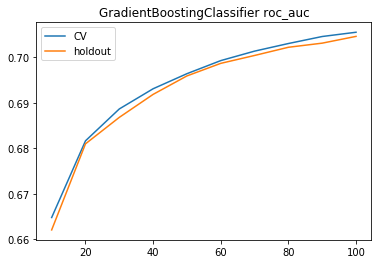

In [64]:
plt.plot(n_estimators, cv_scores, label='CV')
plt.plot(n_estimators, holdout_scores, label='holdout')
plt.title('GradientBoostingClassifier roc_auc')
plt.legend();

## Train

In [216]:
#clf = GradientBoostingClassifier(n_estimators=30).fit(X_train, y_train)
clf = LogisticRegression().fit(X_train, y_train)

# LogisticRegression

## Hyperparameter tuning

## Train

# Comparison

In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_train, X_holdout, y_train, y_holdout = train_test_split(X_scaled, y, test_size=0.3)

In [46]:
from sklearn.ensemble import AdaBoostClassifier
svm_clf = AdaBoostClassifier()
svm_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [47]:
accuracy_score(y_holdout, svm_clf.predict(X_holdout))

0.644554149953718

In [236]:
#plt.figure(figsize = (20,20))
#sns.heatmap(data.corr(), cmap='viridis', annot=True)

In [221]:
accuracy_score(y_holdout, clf.predict(X_holdout))

0.6588844321025746

In [222]:
precision_score(y_holdout, clf.predict(X_holdout))

0.6648257474766711

In [223]:
recall_score(y_holdout, clf.predict(X_holdout))

0.6916066829558212

In [13]:
X_test = pd.read_csv('../features_test.csv')

In [14]:
len(X_test)

17177

In [15]:
X_test.head(5)

,match_id,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
0,6,1430287923,0,93,4,1103,1089,8,0,1,...,0,12.0,247.0,-86.0,272.0,3,4,2,0,118.0
1,7,1430293357,1,20,2,556,570,1,0,0,...,2,-29.0,168.0,-54.0,NaN,3,2,2,1,16.0
2,10,1430301774,1,112,2,751,808,1,0,0,...,1,-22.0,46.0,-87.0,186.0,1,3,3,0,-34.0
3,13,1430323933,1,27,3,708,903,1,1,1,...,2,-49.0,30.0,-89.0,210.0,3,4,2,1,-26.0
4,16,1430331112,1,39,4,1259,661,4,0,0,...,0,36.0,180.0,-86.0,180.0,1,3,2,1,-33.0


In [11]:
sub = pd.read_csv('../sample_submission.csv')
sub.head()

,match_id,radiant_win
0,6,0.518503
1,7,0.518503
2,10,0.518503
3,13,0.518503
4,16,0.518503


In [56]:
X_test.fillna(X_test.mean(), inplace=True)

In [86]:
clf.predict_proba?

In [10]:
len(X_train)

68061